# Introduction

This notebook aims to identify the parameters of the SEIR model develop by Magal & Webb with the behavourial dynamic illustrated in the blog post of John Cochrane "a behavourial SIR model" basically
$$
\begin{align*}
\Delta S_{t+1}  & =-\beta_t S_t \frac{(I_t + U_t)}{N}\\
\Delta I_{t+1}   & =\beta_t S_t\frac{(I_t + U_t)}{N}-\nu I_t\\
\Delta R_{t+1}   & = \nu_1 I_t - \eta R_t \\
\Delta U_{t+1}   &= \nu_2 I_t - \eta U_t
\end{align*}
$$
with $S$ the suceptible, $I$ the infectious, $R$ the reported symptomatic infectious, $U$ the unreported infectious. 
We consider that $\beta_t$ evolves with the dynamic of the reported infectious such that
$$
\log(\beta_t) = \log(\beta_0) - \alpha  \frac{R_{t}}{N} \ ,
$$
This evolution could as well model a policy response or a sum of individual responses fueled by the fear of catch the disease. That's why the model is coined as a behavourial SEIR. 
We also have the 

# The model

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline

In [123]:
# the behavourial SIR model

def behavourial_seir(y0, T, params, N, f):
    alpha, eta, beta_0, nu = params
    nu1, nu2 = f*nu, (1-f)*nu
    yt = np.zeros((4, T+1))
    
    yt[:, 0] = y0
    beta = np.zeros(T)
    
    for t in range(T):
        beta[t] = beta_0 * np.exp(- alpha * yt[2, t]/N)
        
        yt[0, t+1] = yt[0, t] - beta[t] * yt[0, t] * (yt[1, t] + yt[3, t]) / N 
        yt[1, t+1] = yt[1, t] + beta[t] * yt[0, t] * (yt[1, t] + yt[3, t]) / N - nu * yt[1, t]
        yt[2, t+1] = yt[2, t] + nu1 * yt[1, t] - eta * yt[2, t]
        yt[3, t+1] = yt[3, t] + nu2 * yt[1, t] - eta * yt[3, t]
    return yt, beta



With $\alpha = 0$, the model above is the standard SIR model 

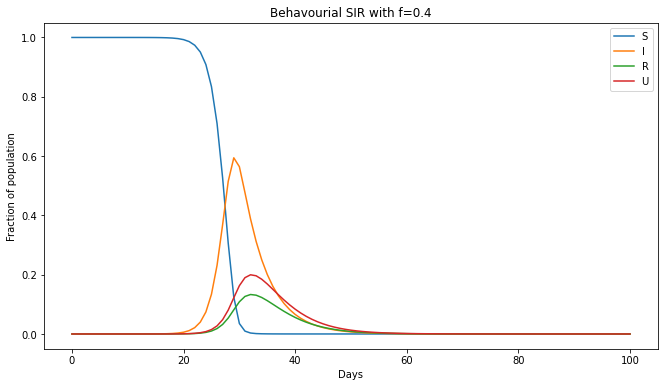

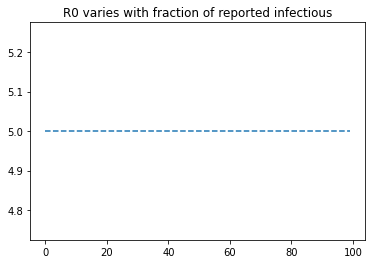

In [213]:
# Standard SIR
T = 100
f = 0.4
params = [0, 0.25, 1, 0.2]
y0 = [60e6, 1, 0, 0]
N = 60e6

res, beta = behavourial_seir(y0, T, params, N, f)

plt.figure(figsize=(11, 6))
plt.plot(range(T+1), res[0, :]/N, label="S")
plt.plot(range(T+1), res[1, :]/N, label="I")
plt.plot(range(T+1), res[2, :]/N, label="R")
plt.plot(range(T+1), res[3, :]/N, label="U")
plt.legend(loc="best")
plt.title(f"Behavourial SIR with f={f}")
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

plt.plot(range(T), beta/params[3], '--')
plt.title("R0 varies with fraction of reported infectious")
plt.show()

This model is validated with the parameters of John Cochrane's blog post

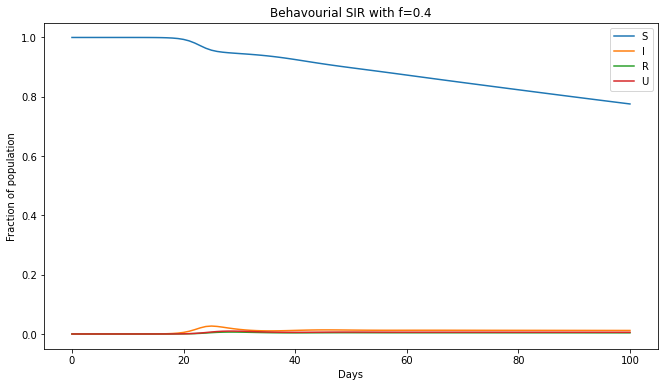

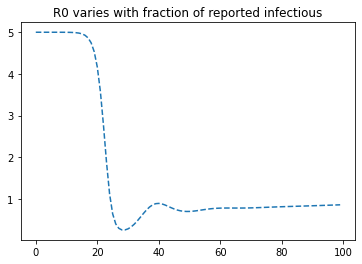

In [214]:
#Behavourial SIR
T = 100
f = 0.4
params = [(0 - np.log(0.1))*1e4/50, 0.25, 1, 0.2]
y0 = [60e6, 1, 0, 0]
N = 60e6

res, beta = behavourial_seir(y0, T, params, N, f)

plt.figure(figsize=(11, 6))
plt.plot(range(T+1), res[0, :]/N, label="S")
plt.plot(range(T+1), res[1, :]/N, label="I")
plt.plot(range(T+1), res[2, :]/N, label="R")
plt.plot(range(T+1), res[3, :]/N, label="U")
plt.legend(loc="best")
plt.title(f"Behavourial SIR with f={f}")
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

plt.plot(range(T), beta/params[3], '--')
plt.title("R0 varies with fraction of reported infectious")
plt.show()

The dynamic is way different from the standard SIR, as we see the $R0$ coefficient drops quickly below $1$ before the 30th day of the pandemic, but goes up avec the peak in the numbers of reported cases.  
The dynamic is also slower than the standard SIR, only $20\%$ of the population catch the disease after 100 days for $f=0.4$.

# Parameters fitting

The measured data correspond to $R(t)$, we consider that the the data $R_{measure}(t)$ are random variables with Poisson distribution (count data). Assuming a gaussian approximation, parameters are fitted using least squares rescaled with Poisson noise. The data used are french confirmed cases from the John Hopkins University github repository.

In [196]:
import pandas as pd
import requests

df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

filtered_df = df[df["Country/Region"] == "France" ]
filtered_df = filtered_df[df["Province/State"].isnull()]
confirmed = filtered_df.iloc[0, 6:].values

/home/clementgauchy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [197]:
confirmed

array([2, 3, 3, 3, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 18, 38, 57,
       100, 130, 191, 204, 285, 377, 653, 949, 1126, 1209, 1784, 2281,
       2281, 3661, 4469, 4499, 6633, 7652, 9043, 10871, 12612, 14282,
       16018, 19856, 22304, 25233, 29155, 32964, 37575, 40174, 44550,
       52128, 56989, 59105, 64338, 68605, 70478, 74390, 78167, 82048,
       86334, 90676, 93790, 120633, 124298, 129257, 132473, 144944,
       146923, 146906, 151808, 154188, 156921, 154715, 157026, 158636,
       160292, 160847, 164589, 167605, 165093, 165764, 165764, 166976,
       167272, 167886, 168935, 172465, 173040, 174318], dtype=object)

In [207]:
from scipy.optimize import minimize, basinhopping
y0 = [60e6, 1, 0, 0]
N = 60e6
f = 0.4

def loglik(params, *args):
    data = args[0]
    T = len(data)
    res, _ = behavourial_seir(y0, T, params, N, f)
    return np.mean([(data[t] - res[2, t]) ** 2 / data[t] for t in range(T)])

params_init = [0, 0.77, 0.339, 0.2]

# "realistic" bounds for the different parameters
bnds = ([0, 438], [0, 1.5], [0.15, 3], [0.0001, 1])

# deterministic L-BFGS-B search to find at least a local optimum
params_star = minimize(loglik, params_init, args=(confirmed), bounds=bnds, method="L-BFGS-B")
params_star



      fun: 1132.7421861361267
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.01235855, -0.07732979,  2.47136995, -1.60050604])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 350
      nit: 24
   status: 0
  success: True
        x: array([4.37980586e+02, 6.37516662e-01, 3.06503259e-01, 9.01730699e-02])

Text(0.5, 1.0, 'Model versus data visualisation')

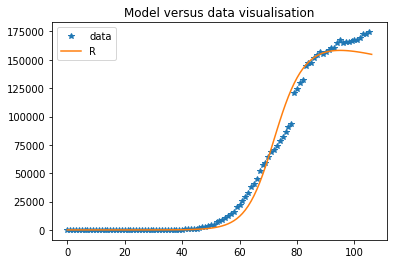

In [208]:
# Validation of the fitting step

T = 106
y0 = [60e6, 1, 0, 0]
N = 60e6

res, beta = behavourial_seir(y0, T, params_star.x, N, f)

plt.plot(range(T), confirmed, '*', label="data")
plt.plot(range(T+1), res[2, :], label="R")
plt.legend(loc="best")
plt.title("Model versus data visualisation")

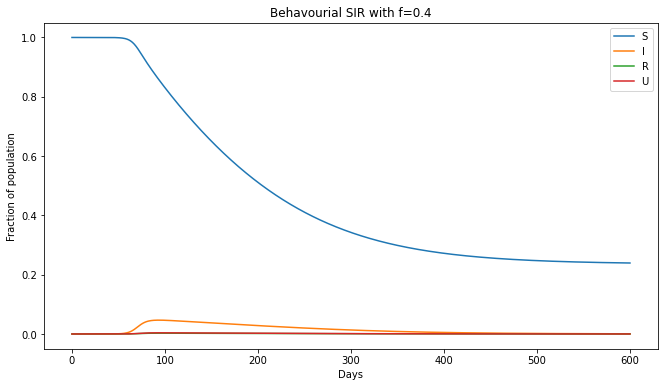

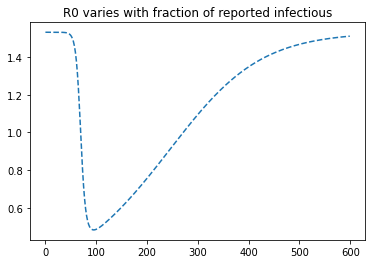

In [209]:
# Prediction with the behavourial SEIR model

T = 600
y0 = [60e6, 1, 0, 0]
N = 60e6

res, beta = behavourial_seir(y0, T, params_star.x, N, f)

plt.figure(figsize=(11, 6))
plt.plot(range(T+1), res[0, :]/N, label="S")
plt.plot(range(T+1), res[1, :]/N, label="I")
plt.plot(range(T+1), res[2, :]/N, label="R")
#plt.plot(range(T), confirmed, '*', label="data")
plt.plot(range(T+1), res[3, :]/N, label="U")
plt.legend(loc="best")
plt.title(f"Behavourial SIR with f={f}")
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

plt.plot(range(T), beta/params[3], '--')
plt.title("R0 varies with fraction of reported infectious")
plt.show()

# Conclusion
This notebook aims at exploiting the behavourial SIR model, coupled with a possibility of infectious patients unreporting. After presenting the model, we investigate a simple way for estimating the several parameters with the French epidemiological data using weighted least squares. 

# References
* John Cochrane - a SIR model with behaviour https://johnhcochrane.blogspot.com/2020/05/an-sir-model-with-behavior.html?m=1

* Magal & Webb - https://www.medrxiv.org/content/10.1101/2020.03.21.20040154v1